# Getting Started with SHAP-IQ
In this tutorial, we explore how to use the shapiq package to uncover and visualize feature interactions in machine learning models using Shapley Interaction Indices (SII), building on the foundation of traditional Shapley values.

Shapley values are great for explaining individual feature contributions in AI models but fail to capture feature interactions. Shapley interactions go a step further by separating individual effects from interactions, offering deeper insights—like how longitude and latitude together influence house prices. In this tutorial, we’ll get started with the shapiq package to compute and explore these Shapley interactions for any model.

## Installing the dependencies

In [1]:
!pip install shapiq overrides scikit-learn pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.3/284.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 21.7 MB/s eta 0:00:00


## Data Loading and Pre-processing
In this tutorial, we'll use the Bike Sharing dataset from OpenML. After loading the data, we'll split it into training and testing sets to prepare it for model training and evaluation.

In [2]:
import shapiq
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

# Load data
X, y = shapiq.load_bike_sharing(to_numpy=True)

# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
df = shapiq.load_bike_sharing()
df[0].head()

,hour,temp,feel_temp,humidity,windspeed,year,month,holiday,weekday,workingday,season,weather
0,-1.000000,-0.8125,-0.683918,0.600000,-1.300268,-1.0,-1.0,0.0,0.75,-1.0,1.0,0.0
1,-0.916667,-0.8750,-0.736714,0.566667,-1.300268,-1.0,-1.0,0.0,0.75,-1.0,1.0,0.0
2,-0.833333,-0.8750,-0.736714,0.566667,-1.300268,-1.0,-1.0,0.0,0.75,-1.0,1.0,0.0
3,-0.750000,-0.8125,-0.683918,0.400000,-1.300268,-1.0,-1.0,0.0,0.75,-1.0,1.0,0.0
4,-0.666667,-0.8125,-0.683918,0.400000,-1.300268,-1.0,-1.0,0.0,0.75,-1.0,1.0,0.0


## Model Training and Performance Evaluation

In [4]:
# Train model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

R² Score: 0.9447
Mean Absolute Error: 24.9615
Root Mean Squared Error: 41.8623


Our model gives an R² score of 0.9447

## Setting up an Explainer
We set up a TabularExplainer using the shapiq package to compute Shapley interaction values based on the k-SII (k-order Shapley Interaction Index) method. By specifying max_order=4, we allow the explainer to consider interactions of up to 4 features simultaneously, enabling deeper insights into how groups of features collectively impact model predictions.

In [5]:
# set up an explainer with k-SII interaction values up to order 4
explainer = shapiq.TabularExplainer(
    model=model,
    data=X,
    index="k-SII",
    max_order=4
)

## Explaining a Local Instance
We select a specific test instance (index 100) to generate local explanations. The code prints the true and predicted values for this instance, followed by a breakdown of its feature values. This helps us understand the exact inputs passed to the model and sets the context for interpreting the Shapley interaction explanations that follow.

In [6]:
from tqdm.asyncio import tqdm
# create explanations for different orders
feature_names = list(df[0].columns)  # get the feature names
n_features = len(feature_names)

# select a local instance to be explained
instance_id = 100
x_explain = X_test[instance_id]
y_true = y_test[instance_id]
y_pred = model.predict(x_explain.reshape(1, -1))[0]
print(f"Instance {instance_id}, True Value: {y_true}, Predicted Value: {y_pred}")
for i, feature in enumerate(feature_names):
    print(f"{feature}: {x_explain[i]}")

Instance 100, True Value: 57.0, Predicted Value: 58.12
hour: -0.16666666666666666
temp: -0.8750000000000001
feel_temp: -0.9996526571726293
humidity: -0.8666666666666666
windspeed: 0.9008042895442363
year: -1.0
month: -1.0
holiday: 0.0
weekday: 0.0
workingday: 0.0
season: 1.0
weather: 0.0


## Analyzing Interaction Values
We use the explainer.explain() method to compute Shapley interaction values for a specific data instance (X[100]) with a budget of 256 model evaluations. This returns an InteractionValues object, which captures how individual features and their combinations influence the model's output. The max_order=4 means we consider interactions involving up to 4 features.

In [7]:
interaction_values = explainer.explain(X[100], budget=256)
# analyse interaction values
print(interaction_values)

InteractionValues(
    index=k-SII, max_order=4, min_order=0, estimated=True, estimation_budget=256,
    n_players=12, baseline_value=190.1859126194499,
    Top 10 interactions:
        (): 190.1859126194499
        (1, 2, 5): 94.3122600778514
        (3, 4, 11): 92.47805831924879
        (5, 7, 9): 83.39265709860865
        (3, 8, 9): 83.01987750249306
        (6, 8, 9): 82.66215127038143
        (4, 5, 8): 74.53089121884368
        (3, 9, 10): 70.46069068753607
        (3, 6, 8): 67.59306277206115
        (0, 7, 10): 67.27108432398458
)


* **baseline_value**: This is the model prediction without using any features,essentially the average prediction.

* **(i, j, k):** value: These are the interaction effects — they quantify how much the group of features (i, j, k) contributes jointly to the prediction. Larger values indicate more important or synergistic interactions.

## First-Order Interaction Values
To keep things simple, we compute first-order interaction values—i.e., standard Shapley values that capture only individual feature contributions (no interactions).

By setting max_order=1 in the TreeExplainer, we're saying:

***“Tell me how much each feature individually contributes to the prediction, without considering any interaction effects.”***

These values are known as standard Shapley values. For each feature, it estimates the average marginal contribution to the prediction across all possible permutations of feature inclusion.


In [8]:
feature_names = list(df[0].columns)
explainer = shapiq.TreeExplainer(model=model, max_order=1, index="SV")
si_order = explainer.explain(x=x_explain)
si_order

InteractionValues(
    index=SV, max_order=1, min_order=0, estimated=False, estimation_budget=None,
    n_players=12, baseline_value=190.7174883118752
)

## Plotting a Waterfall chart
A Waterfall chart visually breaks down a model's prediction into individual feature contributions.
It starts from the baseline prediction and adds/subtracts each feature’s Shapley value to reach the final predicted output.

In our case, we’ll use the output of TreeExplainer with max_order=1 (i.e., individual contributions only) to visualize the contribution of each feature.

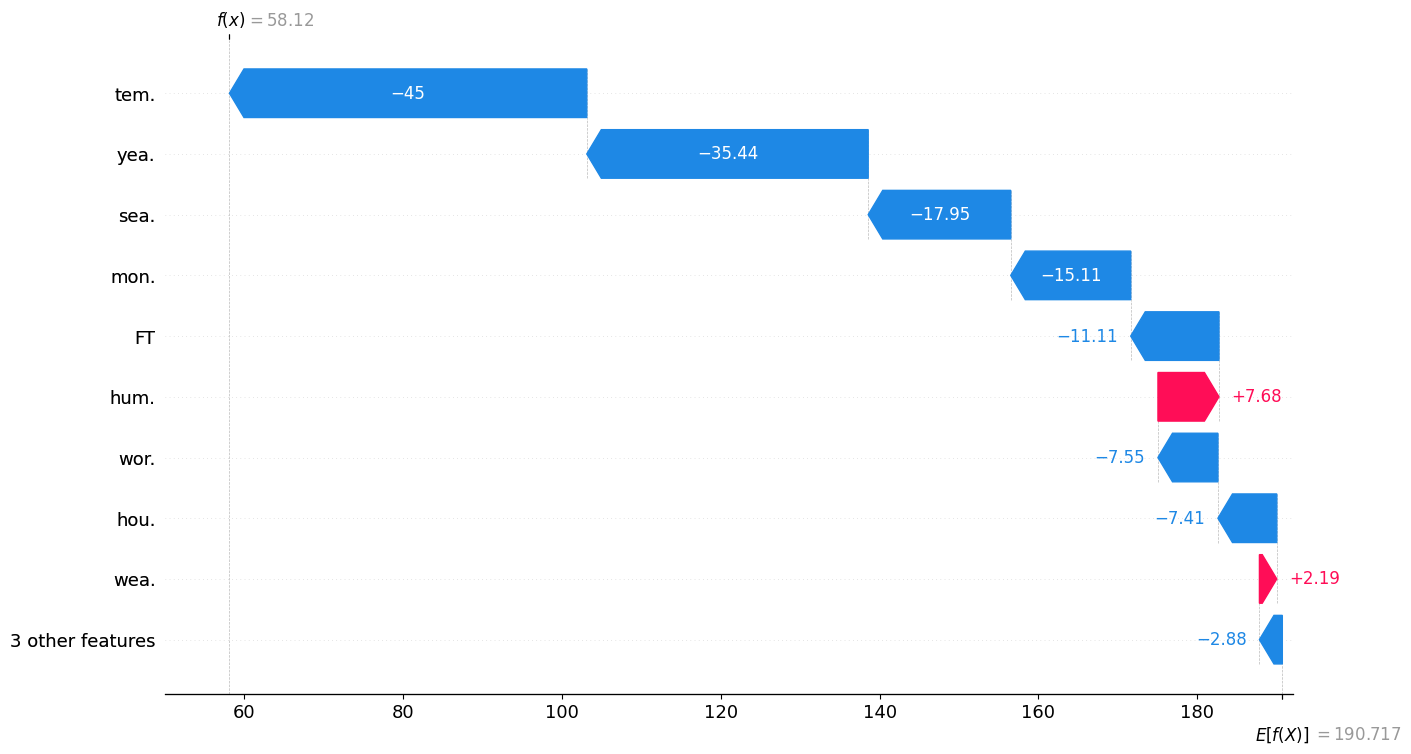

In [10]:
si_order.plot_waterfall(feature_names=feature_names, show=True)

In our case, the baseline value (i.e., the model’s expected output without any feature information) is 190.717.

As we add the contributions from individual features (order-1 Shapley values), we can observe how each one pushes the prediction up or pulls it down:

* Features like Weather and Humidity have a positive contribution, increasing the prediction above the baseline.

* Features like Temperature and Year have a strong negative impact, pulling the prediction down by −35.4 and −45, respectively.

Overall, the Waterfall chart helps us understand which features are driving the prediction, and in which direction—providing valuable insight into the model’s decision-making.